In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pprint as pp
import imp
import matplotlib.pyplot as plt
import networkx as nx
from nxpd import draw

# Norway Pollutant Export model

This notebook illustrates basic usage of a simple export coefficient model based loosely on [TEOTIL](https://brage.bibsys.no/xmlui/bitstream/handle/11250/214825/5914-2010_72dpi.pdf?sequence=1&isAllowed=y). The [previous notebook]() describes preparation of the input file for the new model, and the model code itself can be found [here]().

Note that the model is still very rough and will require further development and debugging before being applied in practice. The aim here is simply to investigate how a TEOTIL-like model can be implemented in Python.

In [2]:
# Import model
nope_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
             r'\Python\rid\notebooks\nope.py')

nope = imp.load_source('nope', nope_path)

## 1. Run model

The model is very easy to run - simply point it to the input file (created [here]()). In the code below we use `%%time` to measure the total runtime (reading the inputs and performing network accumulation).

In [3]:
%%time
# Input file (see previous notebook)
in_csv = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
          r'\Recoding_TEOTIL\Linking_TEOTIL_Input_Files\nope_input_data.csv')

# Run model
g = nope.run_nope(in_csv)

Wall time: 4.96 s


On my laptop, the new model takes just under 4 seconds to process the data for N and P. Running TEOTIL for the same two parameters on the same machine takes approximately 8 hours, so the new model is roughly 7500 times faster. This difference in performance open up more opportunities for testing and calibration, as well as making it much easier to use.

## 2. Explore output

### 2.1. Basic data access

The model returns a "network object", where each node in the network corresponds to a catchment. Each node has two data stores associated with it: one containing the `local` inputs from that specific regine catchment, and a second called `accum` which store accumulated results (i.e. including upstream inputs and retention). These properties can be queried as follows:

In [4]:
# Get local data for catchment '001.1A40'
print 'Local data for "001.1A40":'
pp.pprint(g.node['001.1A40']['local'])
print ''

# Get accum data for catchment '001.1A40'
print 'Accumulated data for "001.1A40":'
pp.pprint(g.node['001.1A40']['accum'])

Local data for "001.1A40":
{'a_reg_km2': 12.37,
 'all_point_n_tonnes': 0.7146448805069999,
 'all_point_p_tonnes': 0.0553334108425,
 'all_sources_n_tonnes': 7.4610984019,
 'all_sources_p_tonnes': 0.327036204762,
 'anth_diff_n_tonnes': 3.57053592494,
 'anth_diff_p_tonnes': 0.223507766884,
 'aqu_n_tonnes': 0.0,
 'aqu_p_tonnes': 0.0,
 'ind_n_tonnes': 0.0,
 'ind_p_tonnes': 0.0,
 'nat_diff_n_tonnes': 3.1759175964499997,
 'nat_diff_p_tonnes': 0.048195027035400004,
 'q_reg_m3/s': 0.170257993391,
 'regine': '001.1A40',
 'regine_ned': '001.1A3',
 'ren_n_tonnes': 0.0,
 'ren_p_tonnes': 0.0,
 'runoff_mm/yr': 434.054654777,
 'spr_n_tonnes': 0.425141672161,
 'spr_p_tonnes': 0.0319314964234,
 'trans_n': 1.0,
 'trans_p': 1.0}

Accumulated data for "001.1A40":
{'all_point_n_tonnes': 1.6177791441419354,
 'all_point_p_tonnes': 0.08619126745694974,
 'all_sources_n_tonnes': 45.68624566524923,
 'all_sources_p_tonnes': 0.7575869176492867,
 'anth_diff_n_tonnes': 6.8975003744165395,
 'anth_diff_p_tonnes': 0.345

### 2.2. Network diagrams

The model can create schematic diagrams upstream and downstream from any node. These can be annotated with any output value the user chooses. Note that if the user specifies "direct='up'", *the arrows on the schematic will point upstream*.

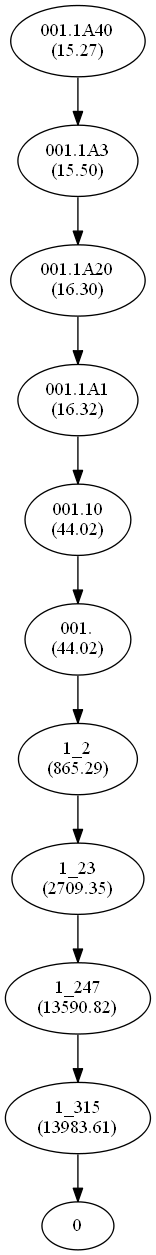

In [5]:
# Plot network labelled with accumulated flow
g2 = nope.plot_network(g, '001.1A40', direct='down', stat='accum', quant='q_m3/s')
draw(g2, show='ipynb')

### 2.3. Summary maps

The user can also choose `local` or `accum` and specify a parameter of interest to generate a simple map. Note that this can take a minute or so, as rendering the regine polygons is computationally intensive. Optionally, the data can be square-root transformed before plotting, and different colour schemes can be applied. The plot can also be saved as an image file by specifying the `plot_path`.

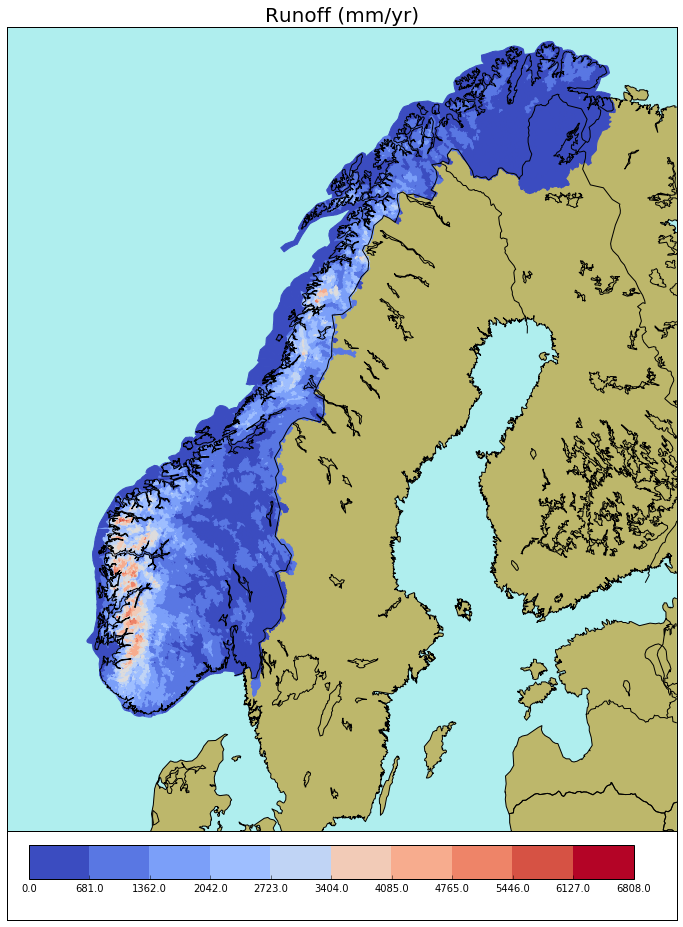

In [6]:
# Summary map of local runoff
out_png = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\Results\PNG_Maps\runoff.png')

fig = nope.make_map(g, stat='local', quant='runoff_mm/yr', sqrt=False,
                    cmap='coolwarm', n_cats=10, plot_path=out_png)

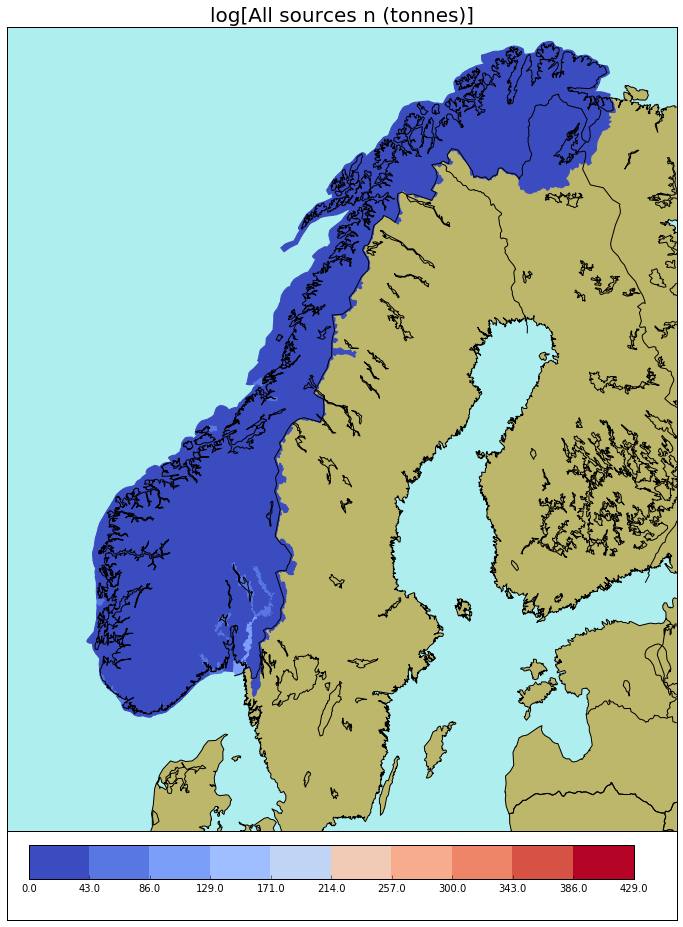

In [8]:
# Summary map of accum total N
out_png = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\Results\PNG_Maps\all_n.png')

fig = nope.make_map(g, stat='accum', quant='all_sources_n_tonnes', sqrt=True,
                    cmap='coolwarm', n_cats=10, plot_path=out_png)